# OpenCV Overlay: Filter2D and Remap

This notebook illustrates the kinds of things you can do with accelerated openCV cores built as PYNQ overlay. The overlay consists of a 2D filter and a remap function and this example notebook does the following.
1. Sets up HDMI drivers
2. Run software only remap on HDMI input and output results on HDMI output
3. Sets up widget for controlling the position, size, and zoom of the "magnifying glass"
4. Run hardware accelerated remap function
5. Run hardware accelerated filter2D + remap function

NOTE: Rough FPS values are computed for each stage

## Program overlay

Here we program the overlay and load the pynq python libraries for a memory manager and the accelerator drivers.
NOTE: All overlay and python libraries should be loaded prior to assigning the HDMI input/outputs. This is necessary right now to ensure correct functionality but will be enhanced in future releases. For now, please copy this block as is when using it in your own designs.

In [1]:
# Load filter2D + remap overlay
from pynq import Overlay
bareHDMI = Overlay("/usr/local/lib/python3.6/dist-packages/"
               "pynq_cv/overlays/xv2Filter2DRemap.bit")
import pynq_cv.overlays.xv2Filter2DRemap as xv2

# Load xlnk memory mangager
from pynq import Xlnk
Xlnk.set_allocator_library("/usr/local/lib/python3.6/dist-packages/"
                           "pynq_cv/overlays/xv2Filter2DRemap.so")
mem_manager = Xlnk()

hdmi_in = bareHDMI.video.hdmi_in
hdmi_out = bareHDMI.video.hdmi_out

## Setup and configure HDMI drivers 

~15 seconds to initialize HDMI input/output

In [2]:
from pynq.lib.video import *
hdmi_in.configure(PIXEL_GRAY)
hdmi_out.configure(hdmi_in.mode)

hdmi_in.cacheable_frames = False
hdmi_out.cacheable_frames = False

hdmi_in.start()
hdmi_out.start()

## Setup up HDMI input/output parameters 

These parameters are referenced in later function calls

In [3]:
mymode = hdmi_in.mode
print("My mode: "+str(mymode))

height = hdmi_in.mode.height
width = hdmi_in.mode.width
bpp = hdmi_in.mode.bits_per_pixel

My mode: VideoMode: width=1920 height=1080 bpp=8


## Define helper functions

This function computes the map matrices used in the remap function. This is not part of the accelerated function and is only called when the "magnifying glass" is moved or its parameters changed.

In [4]:
import numpy as np
import cv2

def makeMapCircleZoom(width, height, cx, cy, radius, zoom):
    mapY, mapX = np.indices((height,width),dtype=np.float32)
    
    for (j,i),x in np.ndenumerate(mapX[cy-radius:cy+radius,
                                       cx-radius:cx+radius]):
        x = i - radius
        y = j - radius
        i += cx-radius
        j += cy-radius
        mapX[(j,i)] = (cx + x/zoom) if (np.sqrt(x*x+y*y)<radius) else i
        mapY[(j,i)] = (cy + y/zoom) if (np.sqrt(x*x+y*y)<radius) else j

    return(mapX,mapY)

## Run SW remap 

~12 seconds

This runs the remap kernel which puts a "magnifying glass" circle over a section of the image. The circle is small and can have it's position, size and zoom modified by changing the constants.

In [5]:
import numpy as np
import timep
import cv2

map1, map2 = makeMapCircleZoom(width,height,1200,540,60,2.0)

numframes = 12

start = time.time()
for _ in range(numframes):
    inframe = hdmi_in.readframe()
    outframe = hdmi_out.newframe()
    cv2.remap(inframe, map1, map2, cv2.INTER_LINEAR, dst=outframe)
    inframe.freebuffer()
    hdmi_out.writeframe(outframe)
end = time.time()

print("Frames per second:  " + str(numframes / (end - start)))

Frames per second:  1.285420382805219


Show input frame in notebook.

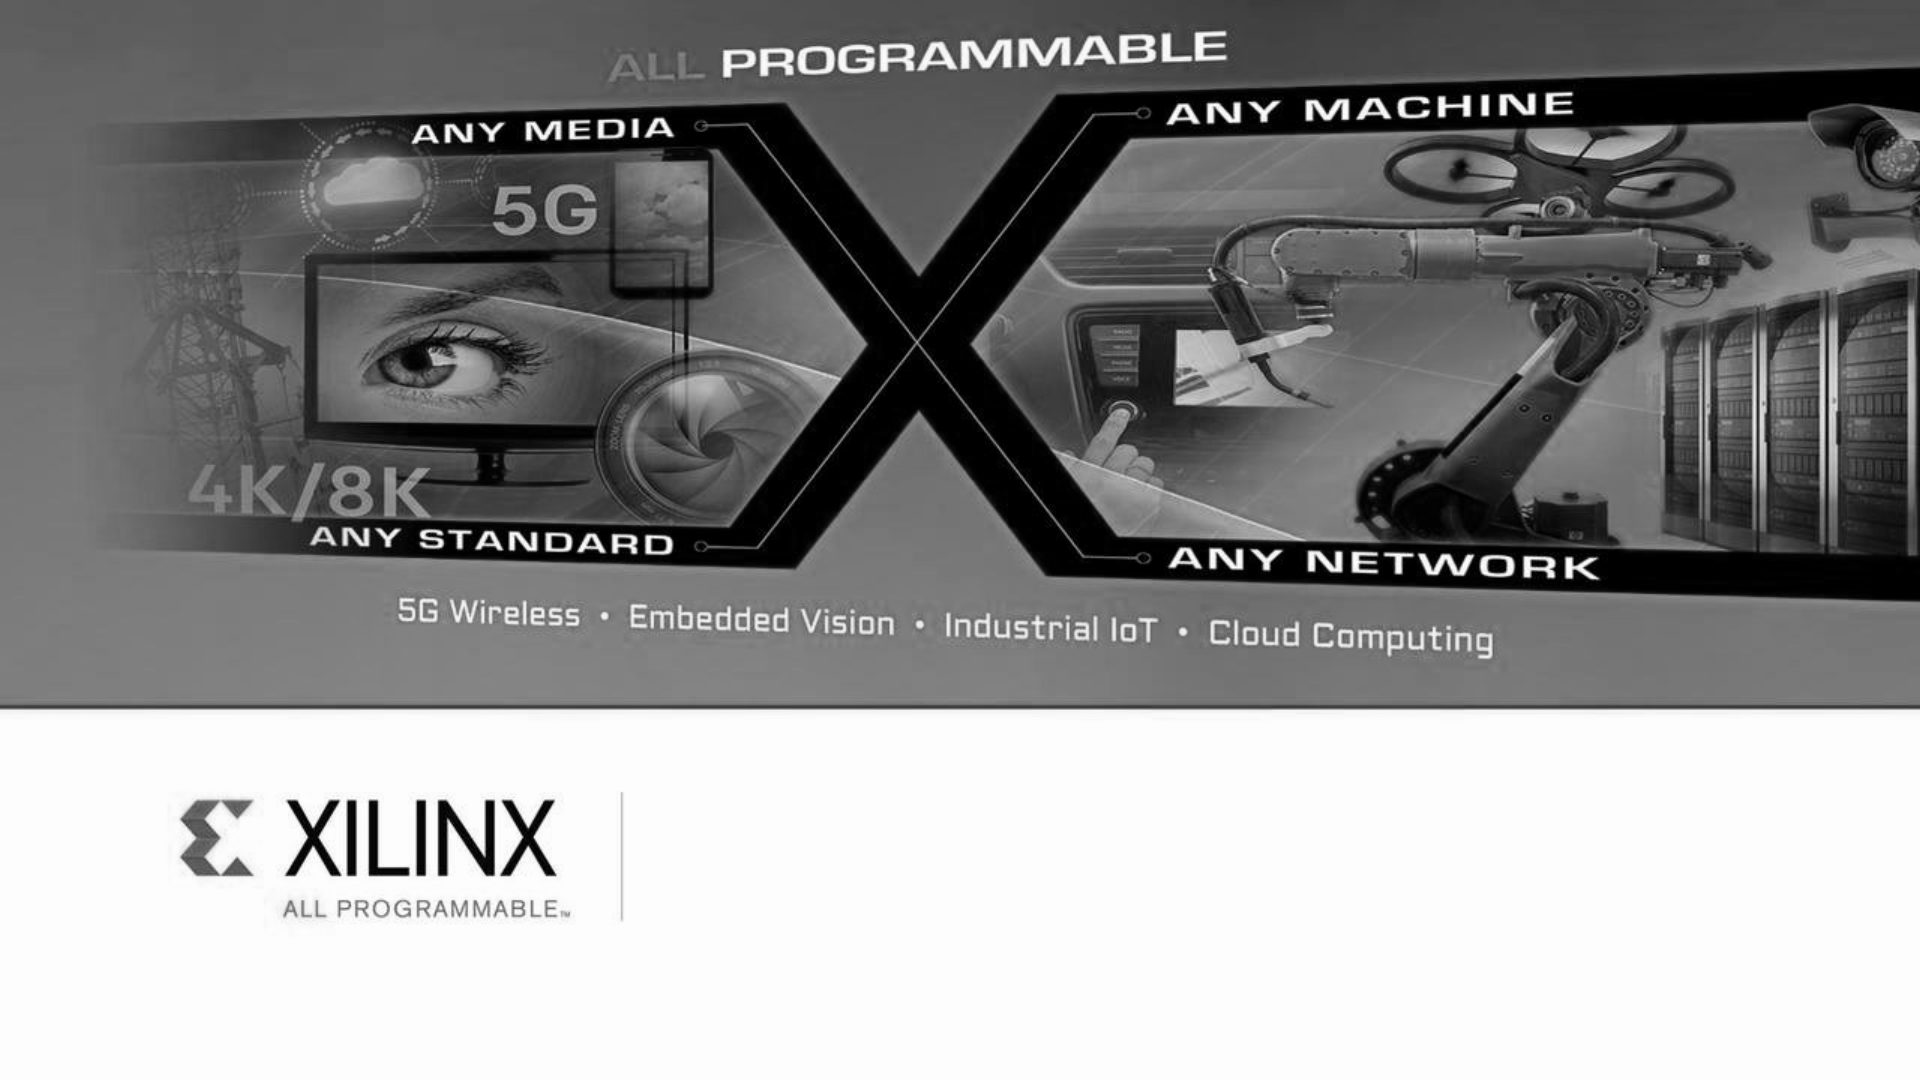

In [6]:
import PIL.Image

image = PIL.Image.fromarray(inframe)
image

Show output frame after remap in notebook.

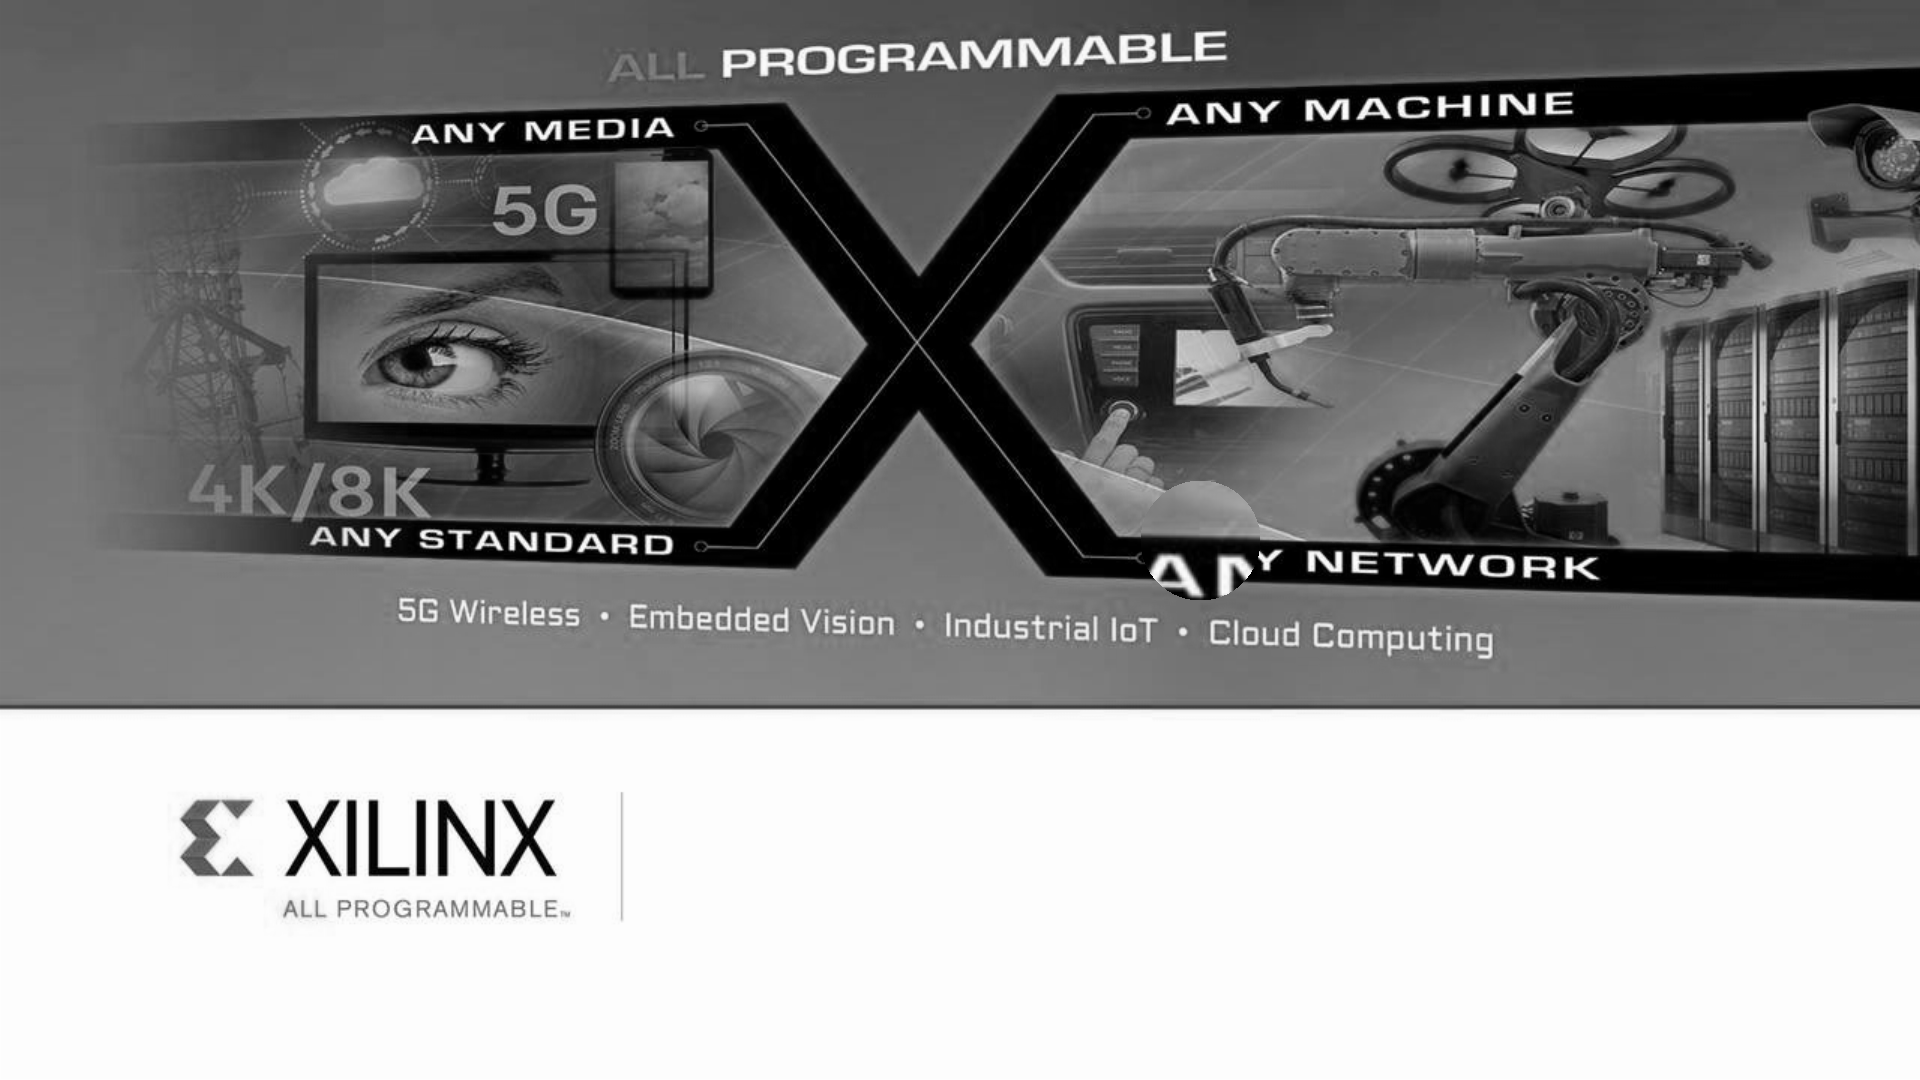

In [7]:
import PIL.Image

image = PIL.Image.fromarray(outframe)
image

## Setup control widgets

This widget controls our "magnifying glass." This demo allows the uses to change the position (x,y), size and zoom of the magnifying glass via slider controls.

In [8]:
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import IntSlider, FloatSlider
import ipywidgets as widgets

var_changed_g = 0
cx_g = width/2+240
cy_g = height/2
radius_g = 60
zoom_g = 2.0

def makeMapCircleZoomAndUpdate(width, height, cx, cy, radius, zoom):
    global var_changed_g
    global cx_g
    global cy_g
    global radius_g
    global zoom_g
    #print(var_changed_g,cx,cy,radius,zoom)
    if var_changed_g == 0:
        cx_g = cx
        cy_g = cy
        radius_g = radius
        zoom_g = zoom
        var_changed_g = 1
    #print(cx_g,cy_g,radius_g,zoom_g)
    
width_widget  = width;
height_widget = height;
cx_widget     = IntSlider(min=0,max=width-1, step=1, value=cx_g,
                          continuous_update=False)
cy_widget     = IntSlider(min=0,max=height-1, step=1, value=cy_g,
                          continuous_update=False)
radius_widget = IntSlider(min=1,max=100,step=1,value=radius_g,
                          continuous_update=False)
zoom_widget   = FloatSlider(min=0.1,max=4.0,step=0.1,value=zoom_g,
                            continuous_update=False)

interact(makeMapCircleZoomAndUpdate, width=fixed(width_widget), 
         height=fixed(height_widget), cx=cx_widget,cy=cy_widget,
         radius=radius_widget,zoom=zoom_widget)

interactive(children=(IntSlider(value=1200, continuous_update=False, description='cx', max=1919), IntSlider(value=540, continuous_update=False, description='cy', max=1079), IntSlider(value=60, continuous_update=False, description='radius', min=1), FloatSlider(value=2.0, continuous_update=False, description='zoom', max=4.0, min=0.1), Output()), _dom_classes=('widget-interact',))

<function __main__.makeMapCircleZoomAndUpdate>

## Run HW remap 

~12 seconds, with no parameter changes

Based on a kernel frequency of 100 MHz, this block should run at ~40 fps. This is also true for the filter2D block as well. Moving the sliders will call the makeMapCircleZoom function in python which takes a few seconds to recompute the new maps each time an adjustment is made on any slider. Not moving the slider will give a more accurate FPS measurement of the remap function on its own.

In [9]:
def loop_hw_app():
    global var_changed_g

    map1, map2 = makeMapCircleZoom(width,height,cx_g,cy_g,radius_g,zoom_g)

    xFmap1 = mem_manager.cma_array((height,width),np.float32)
    xFmap2 = mem_manager.cma_array((height,width),np.float32)

    xFmap1[:] = map1[:]
    xFmap2[:] = map2[:]

    var_changed_g == 0
    numframes = 500

    start=time.time()
    for _ in range(numframes):
        inframe = hdmi_in.readframe()
        outframe = hdmi_out.newframe()
        if var_changed_g == 1:
            map1, map2 = makeMapCircleZoom(width, height, cx_g, cy_g, 
                                           radius_g, zoom_g)
            xFmap1[:] = map1[:]
            xFmap2[:] = map2[:]
            var_changed_g = 0
        xv2.remap(inframe, xFmap1, xFmap2, cv2.INTER_LINEAR, dst=outframe)
        inframe.freebuffer()
        hdmi_out.writeframe(outframe)
    end=time.time()

    print("Frames per second:  " + str(numframes / (end - start)))

from threading import Thread

t = Thread(target=loop_hw_app, )
t.start()

Frames per second:  37.48476811300912


Show output remapped frame in notebook.

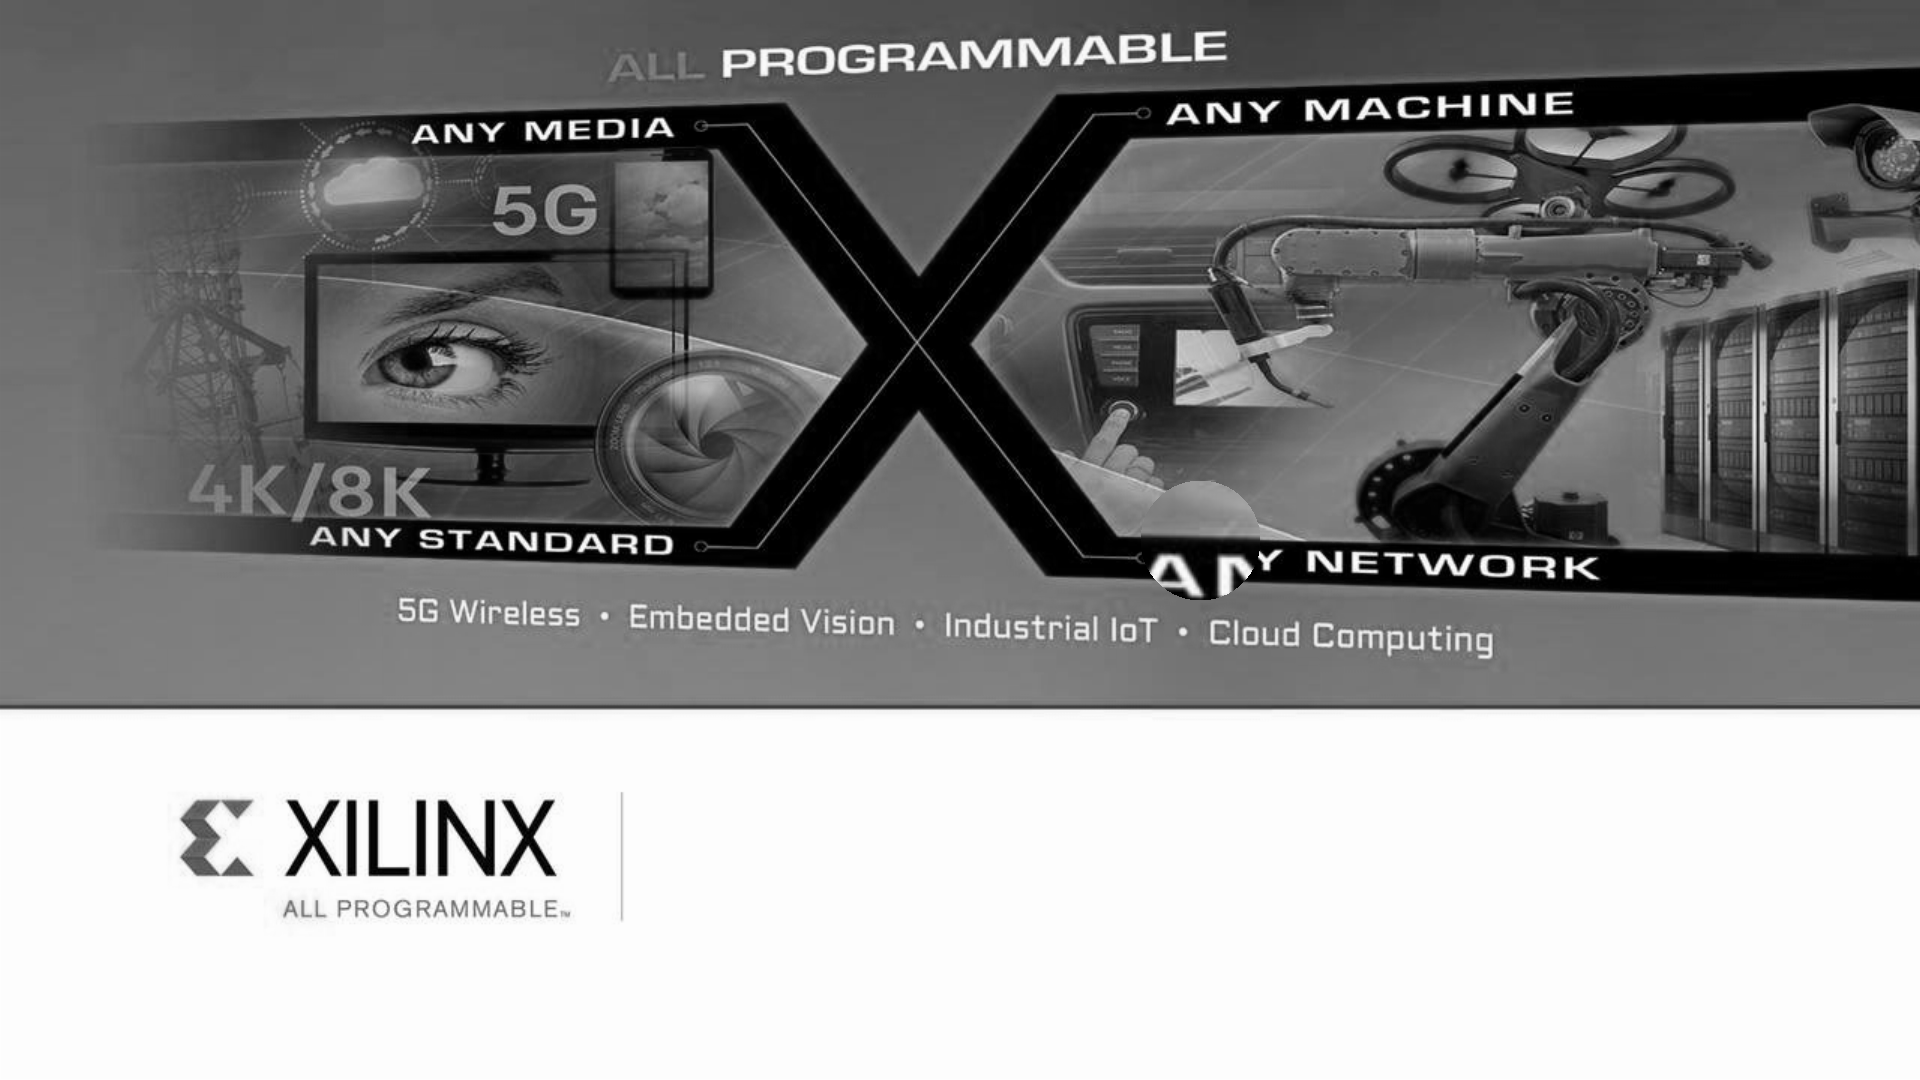

In [10]:
import PIL.Image

image = PIL.Image.fromarray(outframe)
image

## Run HW filter2D + remap 

~10 seconds

Running both blocks in series means the effective performance is approximately halved or ~20 fps.

NOTE: In order to allow kernel redefinition on the fly, subsequent function call are run as threads. This means you will not know if the cell is finished based on the cell status on the left. Be sure to wait until FPS information is reported before running other cells. Also note that if you use the widget to change the kernel, the FPS info will show up underneath the widget cell rather than the function block cell.

In [11]:
buf =np.ones((height,width),np.uint8)
kernel = np.array([[0.0, 1.0, 0],[1.0,-4,1.0],[0,1.0,0.0]],np.float32)

map1, map2 = makeMapCircleZoom(width,height,1200,540,60,2.0)

xFbuf  = mem_manager.cma_array((height,width),np.uint8)
xFmap1 = mem_manager.cma_array((height,width),np.float32)
xFmap2 = mem_manager.cma_array((height,width),np.float32)

xFmap1[:] = map1[:]
xFmap2[:] = map2[:]

numframes = 220

start=time.time()
for _ in range(numframes):
    inframe = hdmi_in.readframe()
    outframe = hdmi_out.newframe()
    xv2.filter2D(inframe, -1, kernel, dst=xFbuf,
                 borderType=cv2.BORDER_CONSTANT)
    xv2.remap(xFbuf, xFmap1, xFmap2, cv2.INTER_LINEAR, dst=outframe)
    inframe.freebuffer()
    hdmi_out.writeframe(outframe)
end=time.time()

print("Frames per second:  " + str(numframes / (end - start)))

Frames per second:  22.46147214653629


Show output filter2d + remapped frame in notebook.

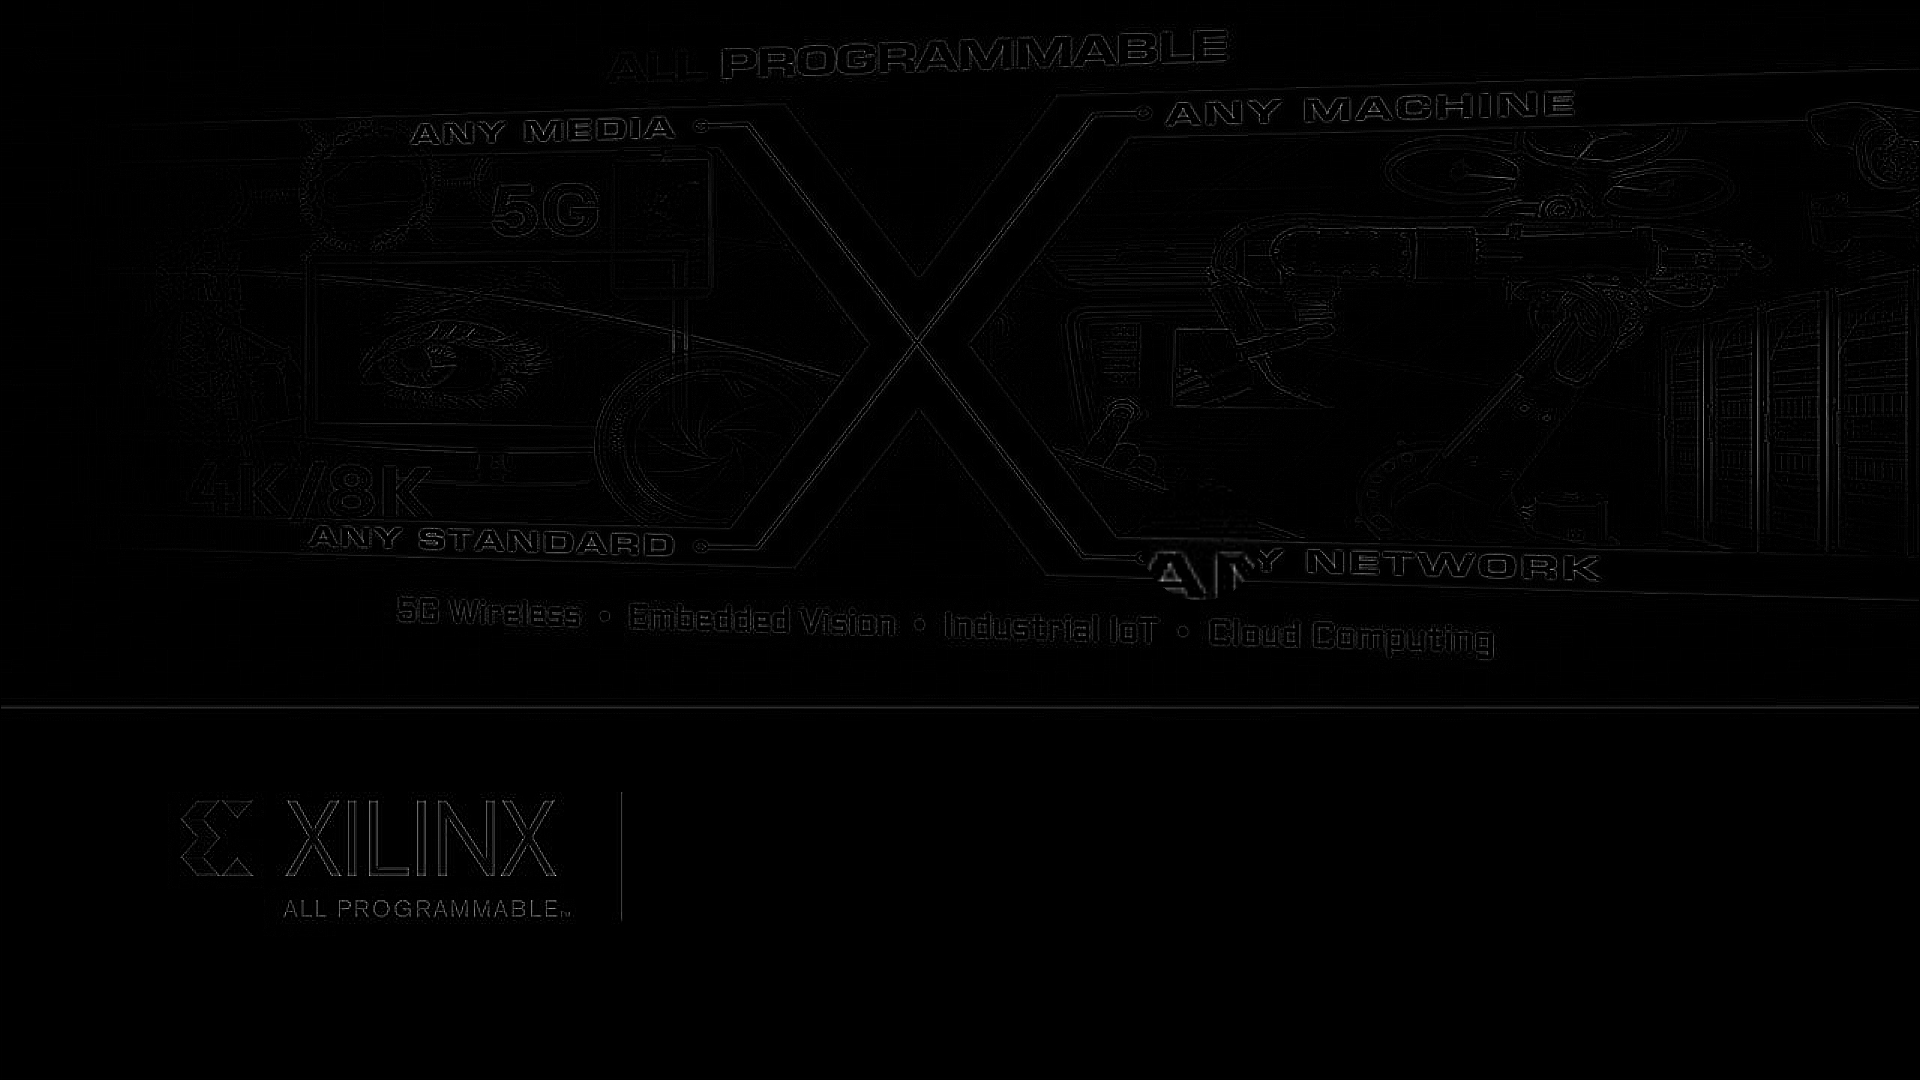

In [12]:
import PIL.Image

image = PIL.Image.fromarray(outframe)
image

## Clean up hdmi drivers

NOTE: This is needed to reset the HDMI drivers in a clean state. If this is not run, subsequent executions of this notebook may show visual artifacts on the HDMI out (usually a shifted output image)

In [13]:
hdmi_out.close()
hdmi_in.close()